# MCMC fitting
In this notebook, I will read in the RV data and perform the MCMC fit to find the mass-ratio.

[for now, I am writing up how to do an SB2 fit. If that fails again, I will fall back to a partial fit using Stefano's parameters.]

In [5]:
import numpy as np
import pandas as pd
import MassRatio_Fitter
import triangle
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')
sns.set_style('ticks')
%matplotlib inline

In [3]:
# Read in the austral rv fits
rv1_data = pd.read_fwf('data/psi1draa_140p_28_37_ASW.dat', header=None)
t1 = rv1_data[0].values
rv1 = rv1_data[2].values / 1000. # Convert from m/s to km/s
rv1_err = rv1_data[3].values / 1000.

# Read in my measurements for the companion RV
t2, _, _, rv2, rv2_err = np.loadtxt('data/rv_data.txt')
good = (~np.isnan(rv2)) & (t2 > t2[20])  #Exclude the early points that I don't trust, and the couple others that have no measurements
t2 = t2[good]
rv2 = rv2[good]
rv2_err = rv2_err[good]

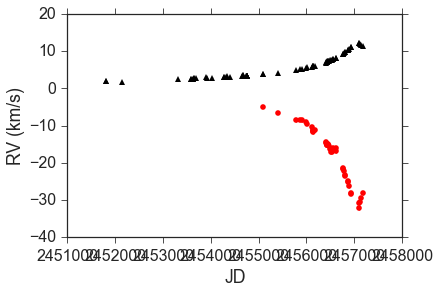

In [6]:
# Plot the RV data just to make sure it looks right
plt.errorbar(t1, rv1, yerr=rv1_err, fmt='k^')
plt.errorbar(t2, rv2, yerr=rv2_err*0.1, fmt='ro')
plt.xlabel('JD')
plt.ylabel('RV (km/s)')

In [4]:
# Do the fit
#reload(MassRatio_Fitter)
sampler = MassRatio_Fitter.full_sb2_fit(t1, rv1, rv1_err, t2, rv2, rv2_err, Niter=1500)

Done with iteration 000
Done with iteration 010
Done with iteration 020
Done with iteration 030
Done with iteration 040
Done with iteration 050
Done with iteration 060
Done with iteration 070
Done with iteration 080
Done with iteration 090
Done with iteration 100
Done with iteration 110
Done with iteration 120
Done with iteration 130
Done with iteration 140
Done with iteration 150
Done with iteration 160
Done with iteration 170
Done with iteration 180
Done with iteration 190
Done with iteration 200
Done with iteration 210
Done with iteration 220
Done with iteration 230
Done with iteration 240
Done with iteration 250
Done with iteration 260
Done with iteration 270
Done with iteration 280
Done with iteration 290
Done with iteration 300
Done with iteration 310
Done with iteration 320
Done with iteration 330
Done with iteration 340
Done with iteration 350
Done with iteration 360
Done with iteration 370
Done with iteration 380
Done with iteration 390
Done with iteration 400
Done with iterat

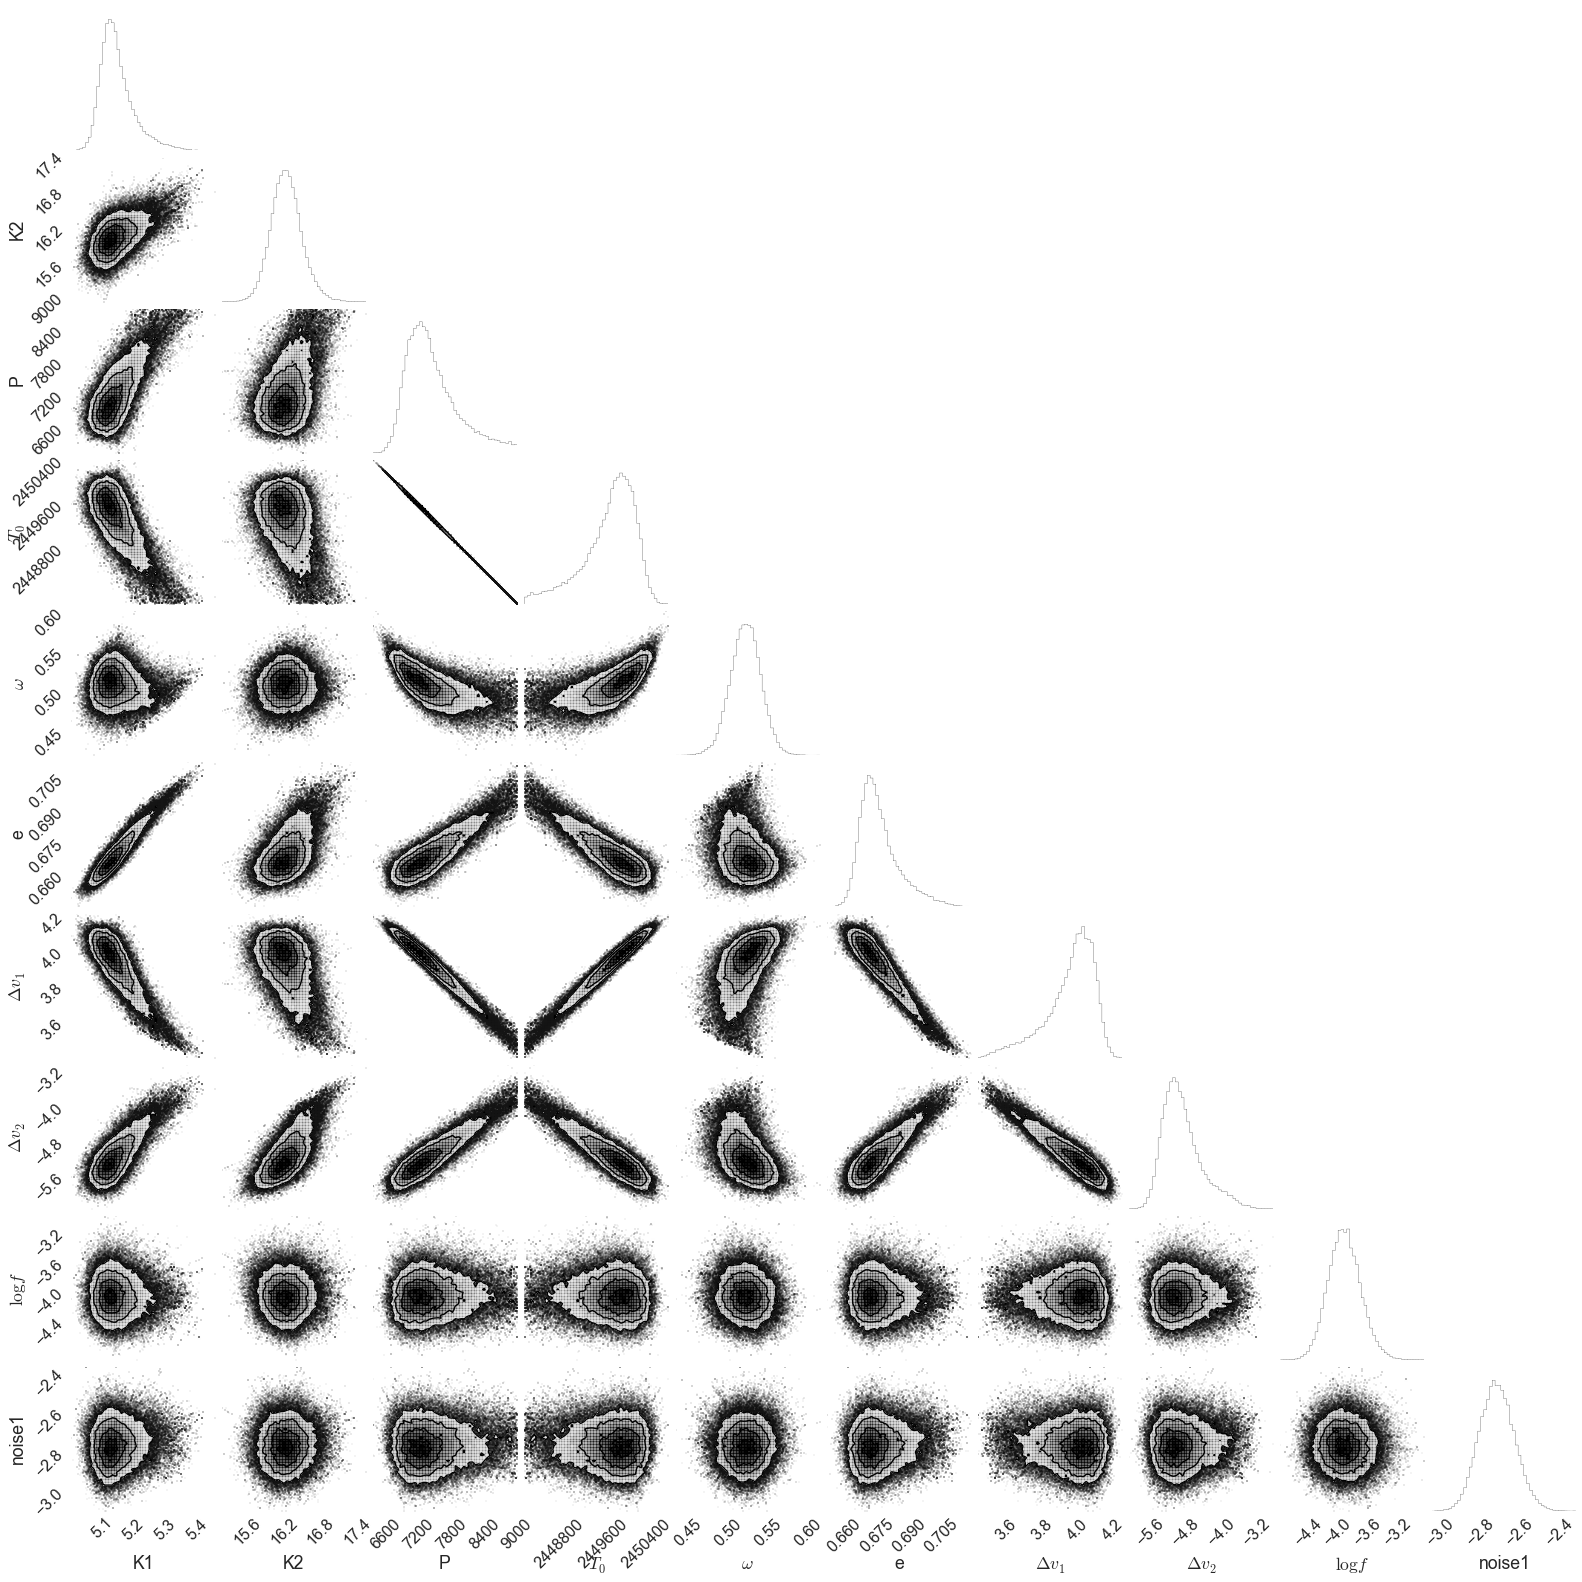

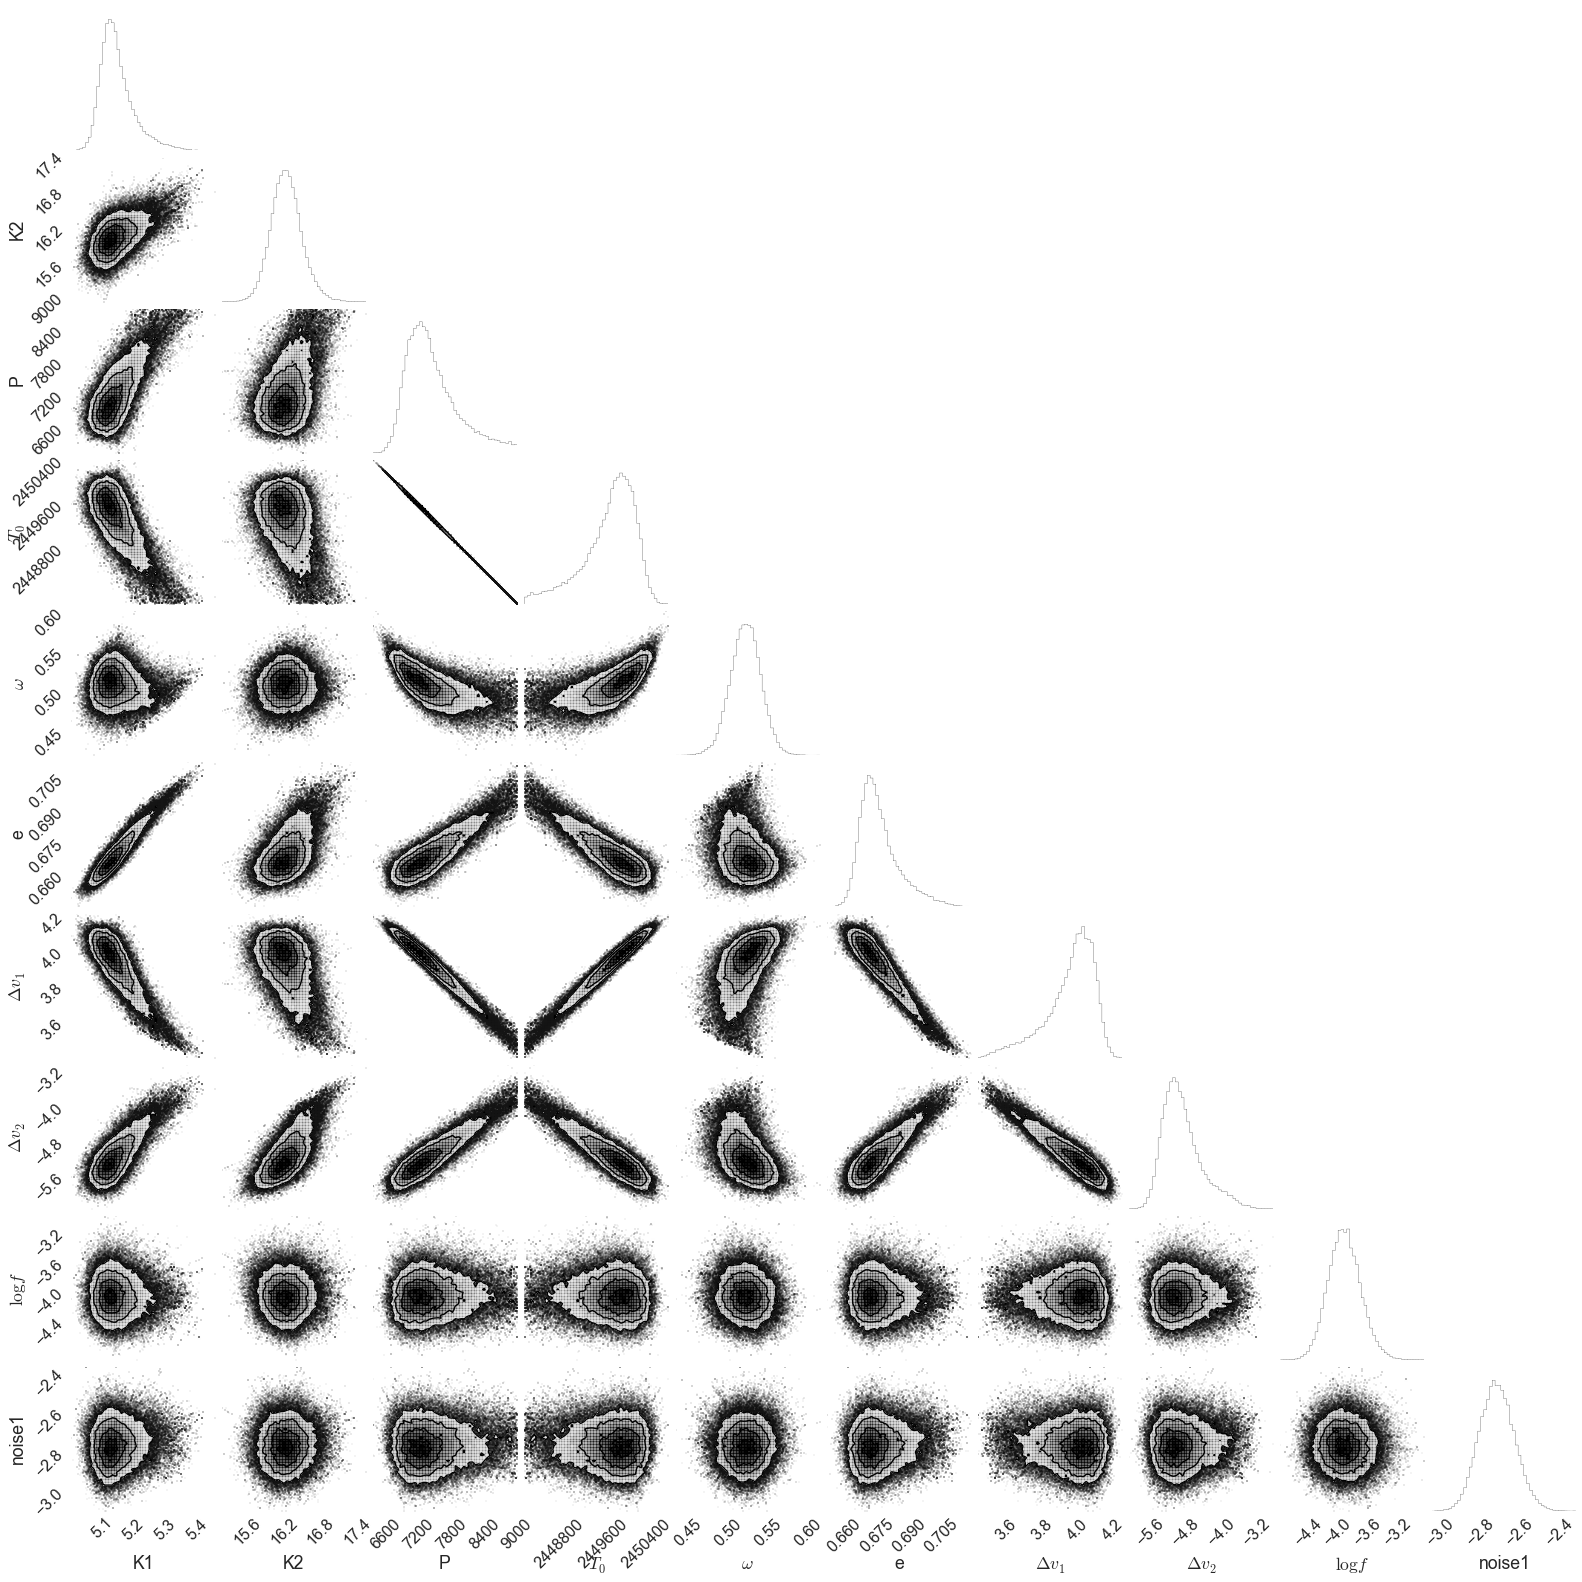

In [5]:
# Visualize with an "everything vs everything" plot
#out = plt.plot(sampler.chain[:, :, 9].T, 'k-', alpha=0.05)
samples = sampler.chain[:, 500:, :].reshape((-1, sampler.chain.shape[-1]))
triangle.corner(samples, labels=['K1', 'K2', 'P', '$T_0$', '$\omega$', 'e', '$\Delta v_1$', '$\Delta v_2$', '$\log{f}$', 'noise1', 'noise2'])
#plt.savefig('../Paper/Figures/SB2_Corner.pdf')

In [2]:
samples = np.load('data/SB2_samples.npy')

q = 0.465 +0.009 / -0.008


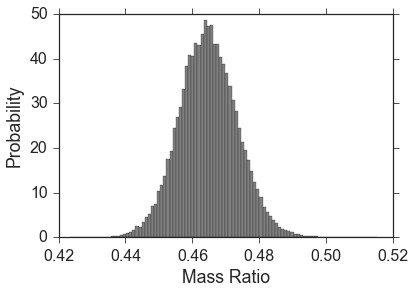

In [8]:
# Measure the mass-ratio
K1 = samples[:, 0]
K2 = samples[:, 1]
q = K1 / K2
out = plt.hist(q, bins=100, color='gray', normed=True)
plt.xlabel('Mass Ratio')
plt.ylabel('Probability')

l, m, h = np.percentile(q, [16, 50, 84])
print('q = {:.3f} +{:.3f} / -{:.3f}'.format(m, h-m, m-l))
plt.savefig('../Paper/Figures/MassRatio.pdf')

In [26]:
# Determine the value of each parameter
def print_val(label, samp, fmt='{:s} = {:.3f} + {:.3f} / - {:.3f}'):
    l, m, h = np.percentile(samp, [16, 50, 84])
    s = fmt.format(label, m, h-m, m-l)
    print(s)
    return s

variables = ['K1', 'K2', 'Period', 'T0', 'w', 'e', 'dv1', 'dv2', 'lnf', 'noise']
for i, var_name in enumerate(variables):
    if var_name == 'w':
        s = print_val(var_name, samples[:, i]*180/np.pi)
    elif var_name == 'lnf':
        s = print_val('f', np.exp(samples[:, i]/2.0))
    elif var_name == 'noise':
        s = print_val('noise', np.exp(samples[:, i]))
    else:
        s = print_val(var_name, samples[:, i])
    

K1 = 5.138 + 0.054 / - 0.037
K2 = 11.072 + 0.224 / - 0.215
Period = 7351.912 + 528.208 / - 335.530
T0 = 2449815.813 + 336.091 / - 527.959
w = 29.840 + 1.088 / - 1.077
e = 0.674 + 0.010 / - 0.006
dv1 = 3.992 + 0.094 / - 0.155
dv2 = -4.973 + 0.484 / - 0.325
f = 0.143 + 0.017 / - 0.015
noise = 0.066 + 0.006 / - 0.005


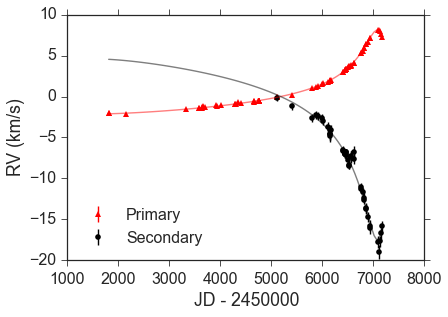

In [10]:
# Make a plot of the best-fit solution (the median of the posterior distribution)
best_pars = np.median(samples, axis=0)
reload(MassRatio_Fitter)
fig, axes = MassRatio_Fitter.plot(best_pars, t1, rv1, rv1_err, t2, rv2, rv2_err, resids=False)
plt.savefig('../Paper/Figures/SB2_Orbit.pdf')

In [28]:
# Save the MCMC samples
np.save('data/SB2_samples.npy', samples)

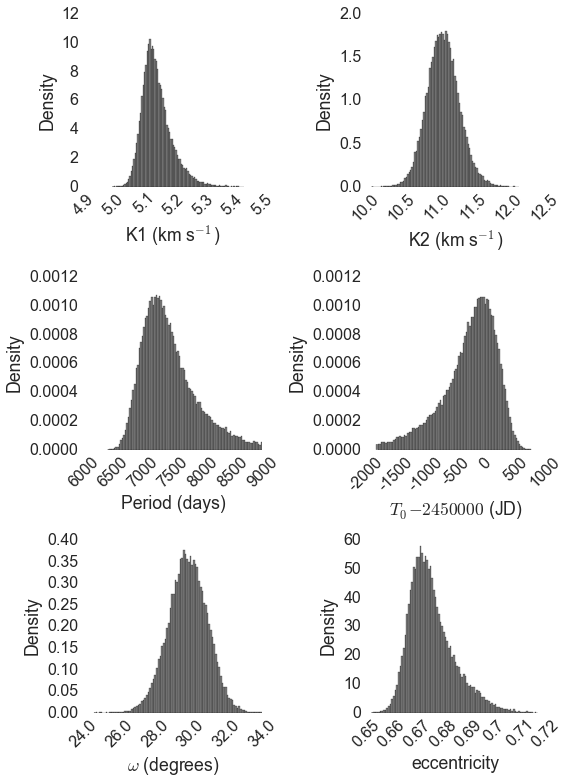

In [29]:
# Plot a histogram for each variable
labels=['K1 (km s$^{-1}$)', 'K2 (km s$^{-1}$)', 'Period (days)', '$T_0 - 2450000$ (JD)', 
        '$\omega$ (degrees)', 'eccentricity', 
        '$\Delta v_1$ (km s$^{-1}$)', '$\Delta v_2$ (km s$^{-1}$)', 'Uncertainty Scale Factor', 'Stellar Noise (m/s)']

fig = plt.figure(figsize=(8, 11))
axes = []
axes.append(fig.add_subplot(321))
axes.append(fig.add_subplot(322))
axes.append(fig.add_subplot(323))
axes.append(fig.add_subplot(324))
axes.append(fig.add_subplot(325))
axes.append(fig.add_subplot(326))

MassRatio_Fitter.sns.set_context('paper', font_scale=2.0)
MassRatio_Fitter.sns.set_style('ticks')
for i, var_name in enumerate(labels[:6]):
    if var_name == '$\omega$ (degrees)':
        s = samples[:, i]*180/np.pi
    elif var_name == 'Uncertainty Scale Factor':
        s = np.exp(samples[:, i]/2.0)
    elif var_name == '$T_0 - 2450000$ (JD)':
        s = samples[:, i] - 2450000
    elif var_name == 'Stellar Noise (m/s)':
        s = np.exp(samples[:, i]) * 1000.0
    else:
        s = samples[:, i]
    
    ax = axes[i]
    ax.hist(s, bins=100, color='gray', normed=True)
    ax.set_xlabel(var_name)
    ax.set_ylabel('Density')
    
    # Format x-ticks
    xticks = ax.get_xticks()
    if var_name in ['Period (days)', '$T_0 - 2450000$ (JD)']:
        xticks = xticks.astype(np.int)
    ax.set_xticklabels(xticks, rotation=45)
    #locs, labels = plt.xticks()
    #plt.setp(labels, rotation=45)

    
plt.tight_layout()
plt.savefig('../Paper/Figures/Distributions_1.pdf')

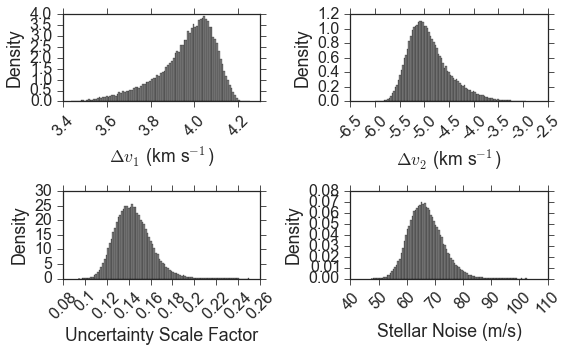

In [32]:
fig = plt.figure(figsize=(8, 5))
axes = []
axes.append(fig.add_subplot(221))
axes.append(fig.add_subplot(222))
axes.append(fig.add_subplot(223))
axes.append(fig.add_subplot(224))

MassRatio_Fitter.sns.set_context('paper', font_scale=2.0)
MassRatio_Fitter.sns.set_style('ticks')
for i, var_name in enumerate(labels[6:]):
    if var_name == '$\omega$ (degrees)':
        s = samples[:, i+6]*180/np.pi
    elif var_name == 'Uncertainty Scale Factor':
        #print sampl
        s = np.exp(samples[:, i+6]/2.0)
    elif var_name == '$T_0 - 2450000$ (JD)':
        s = samples[:, i+6] - 2450000
    elif var_name == 'Stellar Noise (m/s)':
        s = np.exp(samples[:, i+6]) * 1000.0
    else:
        s = samples[:, i+6]
    
    ax = axes[i]
    ax.hist(s, bins=100, color='gray', normed=True)
    ax.set_xlabel(var_name)
    ax.set_ylabel('Density')
    
    # Format x-ticks
    xticks = ax.get_xticks()
    if var_name in ['Stellar Noise (m/s)']:
        xticks = xticks.astype(np.int)
    ax.set_xticklabels(xticks, rotation=45)
    #locs, labels = plt.xticks()
    #plt.setp(labels, rotation=45)

    
plt.tight_layout()
plt.savefig('../Paper/Figures/Distributions_2.pdf')